In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("test").getOrCreate()
sc = spark.sparkContext

In [2]:
stock_1 = spark.read.csv("stock_market_data/sp500/csv/AAPL.csv", inferSchema=True, header=True)

In [3]:
stock_1.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)



In [4]:
from pyspark.sql import functions as F 
close_data = stock_1.select(F.collect_list('Close').alias('Close Price'))
low_data = stock_1.select(F.collect_list('Low').alias('Low Price'))
open_data = stock_1.select(F.collect_list('Open').alias('Open Price'))
volumn_data = stock_1.select(F.collect_list('Volume').alias('Transaction Volume'))
high_data = stock_1.select(F.collect_list('High').alias('High Price'))
adjusted_close_data = stock_1.select(F.collect_list('Adjusted Close').alias('Adjusted Close Price'))

In [5]:
close_price_array = close_data.first()['Close Price']
low_price_array = low_data.first()['Low Price']
open_price_array = open_data.first()['Open Price']
transaction_volume_array = volumn_data.first()['Transaction Volume']
transaction_volume_array = list(map(float, transaction_volume_array))
high_price_array = high_data.first()['High Price']
adjusted_close_price_array = adjusted_close_data.first()['Adjusted Close Price']

In [6]:
date_array = stock_1.select(F.collect_list('Date').alias('Date')).first()['Date']

In [7]:
days = [i for i in range(1, len(date_array) + 1)]

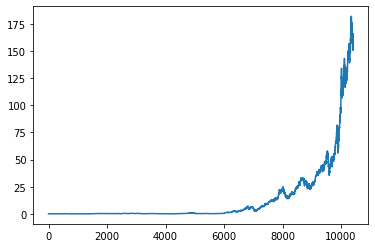

In [8]:
import matplotlib.pyplot as plt
plt.plot(days, close_price_array)

In [9]:
covid_data = spark.read.csv("WHO-COVID-19-global-data.csv", inferSchema=True, header=True)

In [10]:
USA_covid_data = covid_data.filter("Country_code = 'US'")

In [11]:
USA_covid_data.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [12]:
covid_date_array = USA_covid_data.select(F.collect_list('Date_reported').alias('Date')).first()['Date']

In [13]:
def changeDateMode(date):
    elements = date.split('-')
    return elements[2] + '-' + elements[1] + '-' + elements[0]

In [14]:
covid_date_array = list(map(changeDateMode, covid_date_array))

In [15]:
first_day_index = 0
for i in range(0, 3):
    if covid_date_array[i] in date_array:
        first_day_index = date_array.index(covid_date_array[i])
        break

In [16]:
final_day_index = 0
for i in range(1, 4):
    if covid_date_array[len(covid_date_array) - i] in date_array:
        final_day_index = date_array.index(covid_date_array[len(covid_date_array) - i])
        break

In [17]:
first_day_index

9848

In [18]:
final_day_index

10398

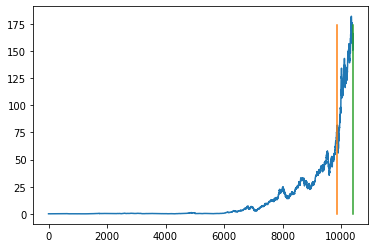

In [19]:
plt.plot(days, close_price_array, [first_day_index] * 175, [i for i in range(0, 175)], [final_day_index] * 175, [i for i in range(0, 175)])

In [20]:
import numpy as np
import sys
def cal_dtw_distance(ts_a, ts_b):
    """Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.

    Arguments
    ---------
    ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared

    d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function

    Returns
    -------
    DTW distance between A and B
    """
    d=lambda x, y: abs(x - y)
    max_warping_window = 10000

    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = sys.maxsize * np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - max_warping_window),
                       min(N, i + max_warping_window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    # Return DTW distance given window
    return cost[-1, -1]

In [21]:
date_gap = 365
step = 100
close_price_array_window = [close_price_array[i:i+date_gap] for i in range(7000, first_day_index - date_gap, step)]

In [22]:
def Z_ScoreNormalization(x,mu,sigma):
    x = (x - mu) / sigma;
    return x;
close_price_array_window_norm = []
for i in range(0, len(close_price_array_window)):
    mu = np.average(close_price_array_window[i])
    sigma = np.std(close_price_array_window[i])
    close_price_array_window_norm.append(Z_ScoreNormalization(close_price_array_window[i], mu, sigma))

In [23]:
close_price_when_covid = close_price_array[first_day_index: first_day_index + date_gap]
close_price_when_covid_norm = Z_ScoreNormalization(close_price_when_covid,
                                                  np.average(close_price_when_covid),
                                                  np.std(close_price_when_covid))

In [24]:
dtws = []
for i in range(0, len(close_price_array_window_norm)):
    dtw = cal_dtw_distance(close_price_array_window_norm[i], close_price_when_covid_norm)
    dtws.append(dtw)

In [25]:
min_index = dtws.index(min(dtws))

In [26]:
min_index

7

In [27]:
close_price_array_window[min_index]

[11.617856979370117,
 11.521785736083984,
 11.829643249511719,
 11.655357360839844,
 11.85857105255127,
 11.973570823669434,
 11.930000305175781,
 11.988213539123535,
 12.259285926818848,
 12.479642868041992,
 12.562856674194336,
 12.757143020629883,
 12.846785545349121,
 12.64285659790039,
 12.633929252624512,
 12.786429405212402,
 12.77750015258789,
 13.032856941223145,
 13.350000381469727,
 13.458929061889648,
 13.817856788635254,
 13.831786155700684,
 14.046428680419922,
 14.23214340209961,
 14.407500267028809,
 14.021071434020996,
 13.993571281433105,
 13.945713996887207,
 14.16964340209961,
 13.889642715454102,
 14.020357131958008,
 13.477499961853027,
 13.343570709228516,
 12.614643096923828,
 13.357500076293945,
 12.98892879486084,
 13.346428871154785,
 13.463929176330566,
 13.693214416503906,
 13.588570594787598,
 13.587142944335938,
 13.073213577270508,
 12.715356826782227,
 12.729999542236328,
 13.342857360839844,
 13.4350004196167,
 13.347143173217773,
 13.699286460876465,


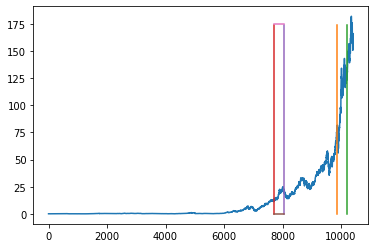

In [28]:
plt.plot(days, close_price_array, 
         [first_day_index] * 175, [i for i in range(0, 175)], 
         [first_day_index + date_gap] * 175, [i for i in range(0, 175)],
         [7000 + min_index*step] * 175, [i for i in range(0,175)],
         [7000 + min_index*step + date_gap] * 175, [i for i in range(0,175)],
         [i for i in range(7000 + min_index*step, 7000 + min_index*step + date_gap)], [0] * date_gap,
         [i for i in range(7000 + min_index*step, 7000 + min_index*step + date_gap)], [175] * date_gap
         )

In [29]:
def min_max_norm(x):
    min_value = min(x)
    max_value = max(x)
    x = np.array(x)
    return (x - min_value)/(max_value - min_value)

In [30]:
low_price_array_norm = min_max_norm(low_price_array)
high_price_array_norm = min_max_norm(high_price_array)
open_price_array_norm = min_max_norm(open_price_array)
transaction_volume_array_norm = min_max_norm(transaction_volume_array)
adjusted_close_price_array_norm = min_max_norm(adjusted_close_price_array)

In [31]:
datas = np.stack((close_price_array, low_price_array_norm, open_price_array_norm, transaction_volume_array_norm, high_price_array_norm, adjusted_close_price_array_norm), axis = 1)
print(datas)

[[1.28347993e-01 4.42511865e-04 4.30949973e-04 6.31981003e-02
  4.33270546e-04 3.40809064e-04]
 [1.21652000e-01 4.05118890e-04 3.97331954e-04 2.36989104e-02
  3.96658479e-04 3.12009993e-04]
 [1.12723000e-01 3.55255959e-04 3.48427418e-04 1.42459064e-02
  3.47836836e-04 2.73607447e-04]
 ...
 [1.60619995e+02 8.79991715e-01 8.68441453e-01 1.01885017e-02
  8.80037389e-01 8.83578738e-01]
 [1.63979996e+02 8.91886387e-01 8.78847797e-01 1.66204756e-02
  8.99065161e-01 9.02066690e-01]
 [1.65580002e+02 9.10063574e-01 8.95278920e-01 4.25988981e-03
  9.05134375e-01 9.10870509e-01]]


In [32]:
import pandas as pd
df = pd.DataFrame(datas, columns=['close_price', 'low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price'])

In [33]:
sparkdf = spark.createDataFrame(df)

In [34]:
sparkdf.show()

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        close_price|           low_price|          open_price|  transaction_volume|          high_price|adjusted_close_price|
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.1283479928970337|4.425118649857621E-4|4.309499733540966E-4| 0.06319810034460305|4.332705461604476E-4|3.408090640789043...|
|0.12165199965238571|4.051188899742423E-4|3.973319536627579...|0.023698910354163192|3.966584793977416...|3.120099933641212E-4|
|0.11272300034761429| 3.55255959161392E-4|3.484274179329132...| 0.01424590637692948|3.478368364379171E-4|  2.7360744713048E-4|
|0.11551299691200256|3.708363619489521E-4|3.606521746245647E-4|0.011647235743341283| 3.63091901598848E-4|2.856068822797584...|
|0.11886200308799744|3.895384871866822...|3.789948186252808E-4|0.009896679451260966|3.814034142368107...|3.0001

In [35]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, VectorIndexer
assembler = VectorAssembler(inputCols=['low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price'], outputCol='features')
output = assembler.transform(sparkdf)
label_features = output.select("features", 'close_price').toDF('features', 'label')
train_data = pd.DataFrame(label_features.toPandas()[0:8000], columns=['features', 'label'])
train_data = spark.createDataFrame(train_data)
test_data = pd.DataFrame(label_features.toPandas()[8000:], columns=['features', 'label'])
test_data = spark.createDataFrame(test_data)
lr = LinearRegression()
lrModel = lr.fit(train_data)

In [36]:
test_result = lrModel.evaluate(test_data)
print("R2: {}".format(test_result.r2))

R2: 0.9499963219779591


In [37]:
test_current_data = df.loc[7000+min_index:7000+min_index+date_gap]

In [38]:
test_current_data = spark.createDataFrame(test_current_data)

In [39]:
test_current_data = assembler.transform(test_current_data)
test_current_data = output.select("features", 'close_price').toDF('features', 'label')
test_result = lrModel.evaluate(test_current_data)
print("R2: {}".format(test_result.r2))

R2: 0.976945615403449


In [40]:
def train_and_test(sparkdf, inputCols, target):
    assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
    output = assembler.transform(sparkdf)
    label_features = output.select('features', target).toDF('features', 'label')
    train_data = pd.DataFrame(label_features.toPandas()[0:8000], columns=['features', 'label'])
    train_data = spark.createDataFrame(train_data)
    test_data = pd.DataFrame(label_features.toPandas()[8000:], columns=['features', 'label'])
    test_data = spark.createDataFrame(test_data)
    lr = LinearRegression()
    lrModel = lr.fit(train_data)
    test_result = lrModel.evaluate(test_data)
    print("R2: {}".format(test_result.r2))
    return test_result.r2

In [41]:
test_results = []
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price']
target = 'close_price'
for i in range(0, 5):
    test_results.append(train_and_test(sparkdf, inputCols[i:i+1], target))

R2: 0.9996952899562686
R2: 0.9994065577779733
R2: -1.5269749623536573
R2: 0.999698825250157
R2: 0.939374536694559


In [42]:
best_determinant = inputCols[test_results.index(max(test_results))]

In [43]:
best_determinant

'high_price'

In [44]:
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price']
determinants = []
determinants.append(best_determinant)
inputCols.remove(best_determinant)
result = max(test_results)
for i in range(0, 4):
    determinants.append(inputCols[i])
    temp_result = train_and_test(sparkdf, determinants, target)
    if temp_result < result:
        determinants.remove(inputCols[i])

R2: 0.9997952049605894
R2: 0.9998575466030256
R2: 0.9998542793210458
R2: 0.9499963219778513


In [45]:
determinants

['high_price', 'low_price', 'open_price', 'transaction_volume']

In [47]:
stock_1.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)



In [62]:
df[['close_price', 'high_price', 'low_price', 'open_price', 'transaction_volume']].loc[7000 + min_index*step:7000 + min_index*step + date_gap].to_excel('')

,close_price,high_price,low_price,open_price,transaction_volume
7700,11.617857,0.063350,0.062590,0.061673,0.066479
7701,11.521786,0.063955,0.064022,0.063332,0.052628
7702,11.829643,0.064500,0.063172,0.062115,0.075423
7703,11.655357,0.064785,0.064562,0.064547,0.059260
7704,11.858571,0.064931,0.064993,0.063807,0.045787
...,...,...,...,...,...
8061,20.885000,0.115024,0.115422,0.115049,0.071861
8062,20.819286,0.114122,0.113859,0.112647,0.070182
8063,21.048571,0.115772,0.116449,0.115180,0.069351
8064,20.902857,0.114629,0.115937,0.114509,0.052727


In [72]:
final_train_data = df[['high_price', 'low_price', 'open_price', 'transaction_volume']].loc[7000 + min_index*step:7000 + min_index*step + date_gap]

In [73]:
final_predict_data = df[['close_price']].loc[7000 + min_index*step + date_gap:7000 + min_index*step + date_gap +date_gap]

In [80]:
newindex = [i for i in range(0, 366)]
final_train_data.index = newindex
final_predict_data.index = newindex

In [81]:
final_train_data.insert(loc=0, column='close_price', value=final_predict_data['close_price'])

In [83]:
final_train_data.to_csv('final_train_data.csv', index=False)